# Stock Compare
This repository will find stocks simmilar to the provided symbol and compare them

In [6]:
sym="SBUX"

In [7]:
import requests
import json
import pandas as pd
%matplotlib inline
import requests
import json
import pandas as pd
from datetime import datetime
from datetime import timedelta
import arrow
import ast
from pytz import timezone
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def summerizekon(df,symbol):
    a=df.iloc[:,0:2]
    b=df.rename(columns={2: 0, 3: 1}).iloc[:,2:4]
    c=df.rename(columns={4: 0, 5: 1}).iloc[:,4:6]
    d=df.rename(columns={6: 0, 7: 1}).iloc[:,6:8]
    e=df.rename(columns={8: 0, 9: 1}).iloc[:,8:10]
    f=df.iloc[:,10:12].rename(columns={10: 0, 11: 1})
    g=pd.concat([a,b,c,d,e,f]).set_index(0)
    g.rename(columns={1:symbol},inplace=True)
    return g

def KMB2_E(s):
    if "M" in s:
        return str(float(s.replace("M",""))*1000000)
    elif "B" in s:
        return str(float(s.replace("B",""))*1000000000)
    elif "K" in s:
        return str(float(s.replace("K",""))*1000)
    else:
        return s
def fillsector(symbol):
    url="https://finance.yahoo.com/quote/"+symbol+"/profile?p="+symbol+"&.tsrc=fin-srch"
    f = requests.get(url)
    try:
        return f.text.split(",\"sector\":")[1].split(",")[0].replace("\"","").replace("}","")
    except:
        return np.NaN

def fillinustry(symbol):
    url="https://finance.yahoo.com/quote/"+symbol+"/profile?p="+symbol+"&.tsrc=fin-srch"
    f = requests.get(url)
    try:
        return f.text.split(",\"industry\":")[2].split(",")[0].replace("\"","").replace("}","")
    except:
        return np.NaN


In [10]:
print("Reading simmilar symbols----------------------------------------------------------------")
url="http://www.market-topology.com/correlation/"+sym
tables = pd.read_html(url)
tables[2].dropna(inplace=True)
tables[2].columns= tables[2].iloc[0,:]
tables[2]=tables[2].iloc[1:-1,:]
tables[2]=tables[2].applymap(lambda x: x.replace("%",""))
tables[2][['Corr.','change','Volatility']]=tables[2][['Corr.','change','Volatility']].astype(np.float16)

c=tables[2]
df=pd.DataFrame(c.values)
df=df.rename(columns={0: "Symbol",1:"Description",2:"Corr %"})
df["sector"]=df["Symbol"].apply(lambda x:fillsector(x))
df["industry"]=df["Symbol"].apply(lambda x:fillinustry(x))
df.drop([3,4],inplace=True,axis=1)

syms=df["Symbol"]
syms.loc[-1]=sym
syms.index=syms.index+1
syms.sort_index(inplace=True)



print("Reading finviz----------------------------------------------------------------")
finviz=pd.DataFrame();
ii=0;
for s in syms:
    ii=ii+1;
    try:

        url = r'https://finviz.com/quote.ashx?t='+s
#         print(ii)
#         print(url)
        try:
            tables = pd.read_html(url) # Returns list of all tables on page
        except Exception as e:
            print(e)
        tt=summerizekon(tables[6],s)
        finviz=pd.concat([finviz,tt],axis=1)
    except:
        pass
finviz.index.names=["Statics"]

print("bringing % to column name----------------------------------------------------------------")
t=finviz.T
for i in t.iloc[0].index:
    try:
        if "%" in t.iloc[0].loc[i]:
            if "%" not in i:
                t=t.rename(columns={i: i+" %"})
    except:
        pass

print("replacing % ( ----------------------------------------------------------------")
t=t.applymap(lambda x: x.replace("%","") if isinstance(x, str) else x)
t=t.applymap(lambda x: x.replace("(","") if isinstance(x, str) else x)
t=t.applymap(lambda x: x.replace(")","") if isinstance(x, str) else x)

print("converting M,B to E ----------------------------------------------------------------")
for i in t.loc[sym].index:
    try:
        if ("B" in t.loc[sym].loc[i] or "M" in t.loc[sym].loc[i] or "K" in t.loc[sym].loc[i]):
            t[i]=t[i].apply(lambda x: KMB2_E(x) )
    except:
        pass
    
print("converting upper and lower to separate fields ----------------------------------------------------------------")
t["Volatility_lower %"]=t["Volatility %"].apply(lambda x: x.split(" ")[0])
t["Volatility_upper %"]=t["Volatility %"].apply(lambda x: x.split(" ")[1])
t.drop(["Volatility %"],inplace=True,axis=1)
t["52W Range_lower"]=t["52W Range"].apply(lambda x: x.split(" - ")[0])
t["52W Range_uper"]=t["52W Range"].apply(lambda x: x.split(" - ")[1])
t.drop(["52W Range"],inplace=True,axis=1)

print("converting to float ----------------------------------------------------------------")
t=t.applymap(lambda x: np.nan if isinstance(x, str) and "-" in x and len(x)==1  else x)
t=t.applymap(lambda x: np.nan if isinstance(x, str) and "--" in x and len(x)==1  else x)
t=t.applymap(lambda x: np.nan if isinstance(x, str) and "---" in x and len(x)==1  else x)
ts=t[["Earnings","Optionable","Shortable","Index"]]
tf=t.drop(ts.columns,axis=1)
tf=tf.applymap(lambda x: float(x))
t=pd.concat([ts,tf],axis=1)

print("filling sector, industry ----------------------------------------------------------------")
t["Symbol"]=t.index

t["sector"]=t["Symbol"].apply(lambda x:fillsector(x))
t["industry"]=t["Symbol"].apply(lambda x:fillinustry(x))

df

Reading simmilar symbols----------------------------------------------------------------
Reading finviz----------------------------------------------------------------
HTTP Error 404: Not Found
bringing % to column name----------------------------------------------------------------
replacing % ( ----------------------------------------------------------------
converting M,B to E ----------------------------------------------------------------
converting upper and lower to separate fields ----------------------------------------------------------------
converting to float ----------------------------------------------------------------
filling sector, industry ----------------------------------------------------------------


,Symbol,Description,Corr %,sector,industry
0,TY,Tri Continental C,56.4062,Financial Services,Asset Management
1,AXP,American Express,56.3125,Financial Services,Credit Services
2,ADX,Adams Express Com,54.8125,Financial Services,Asset Management
3,TXRH,"Texas Roadhouse,",51.8125,Consumer Cyclical,Restaurants
4,YUM,"Yum! Brands, Inc.",51.5938,Consumer Cyclical,Restaurants
5,DIS,Walt Disney Compa,51.5,Consumer Cyclical,Media - Diversified
6,NIE,AllianzGI Equity,51.4062,Financial Services,Asset Management
7,USA,Liberty All-Star,51.0938,Financial Services,Asset Management
8,HIG,Hartford Financia,51,Financial Services,Insurance - Diversified
9,LNC,Lincoln National,51,Financial Services,Insurance - Life


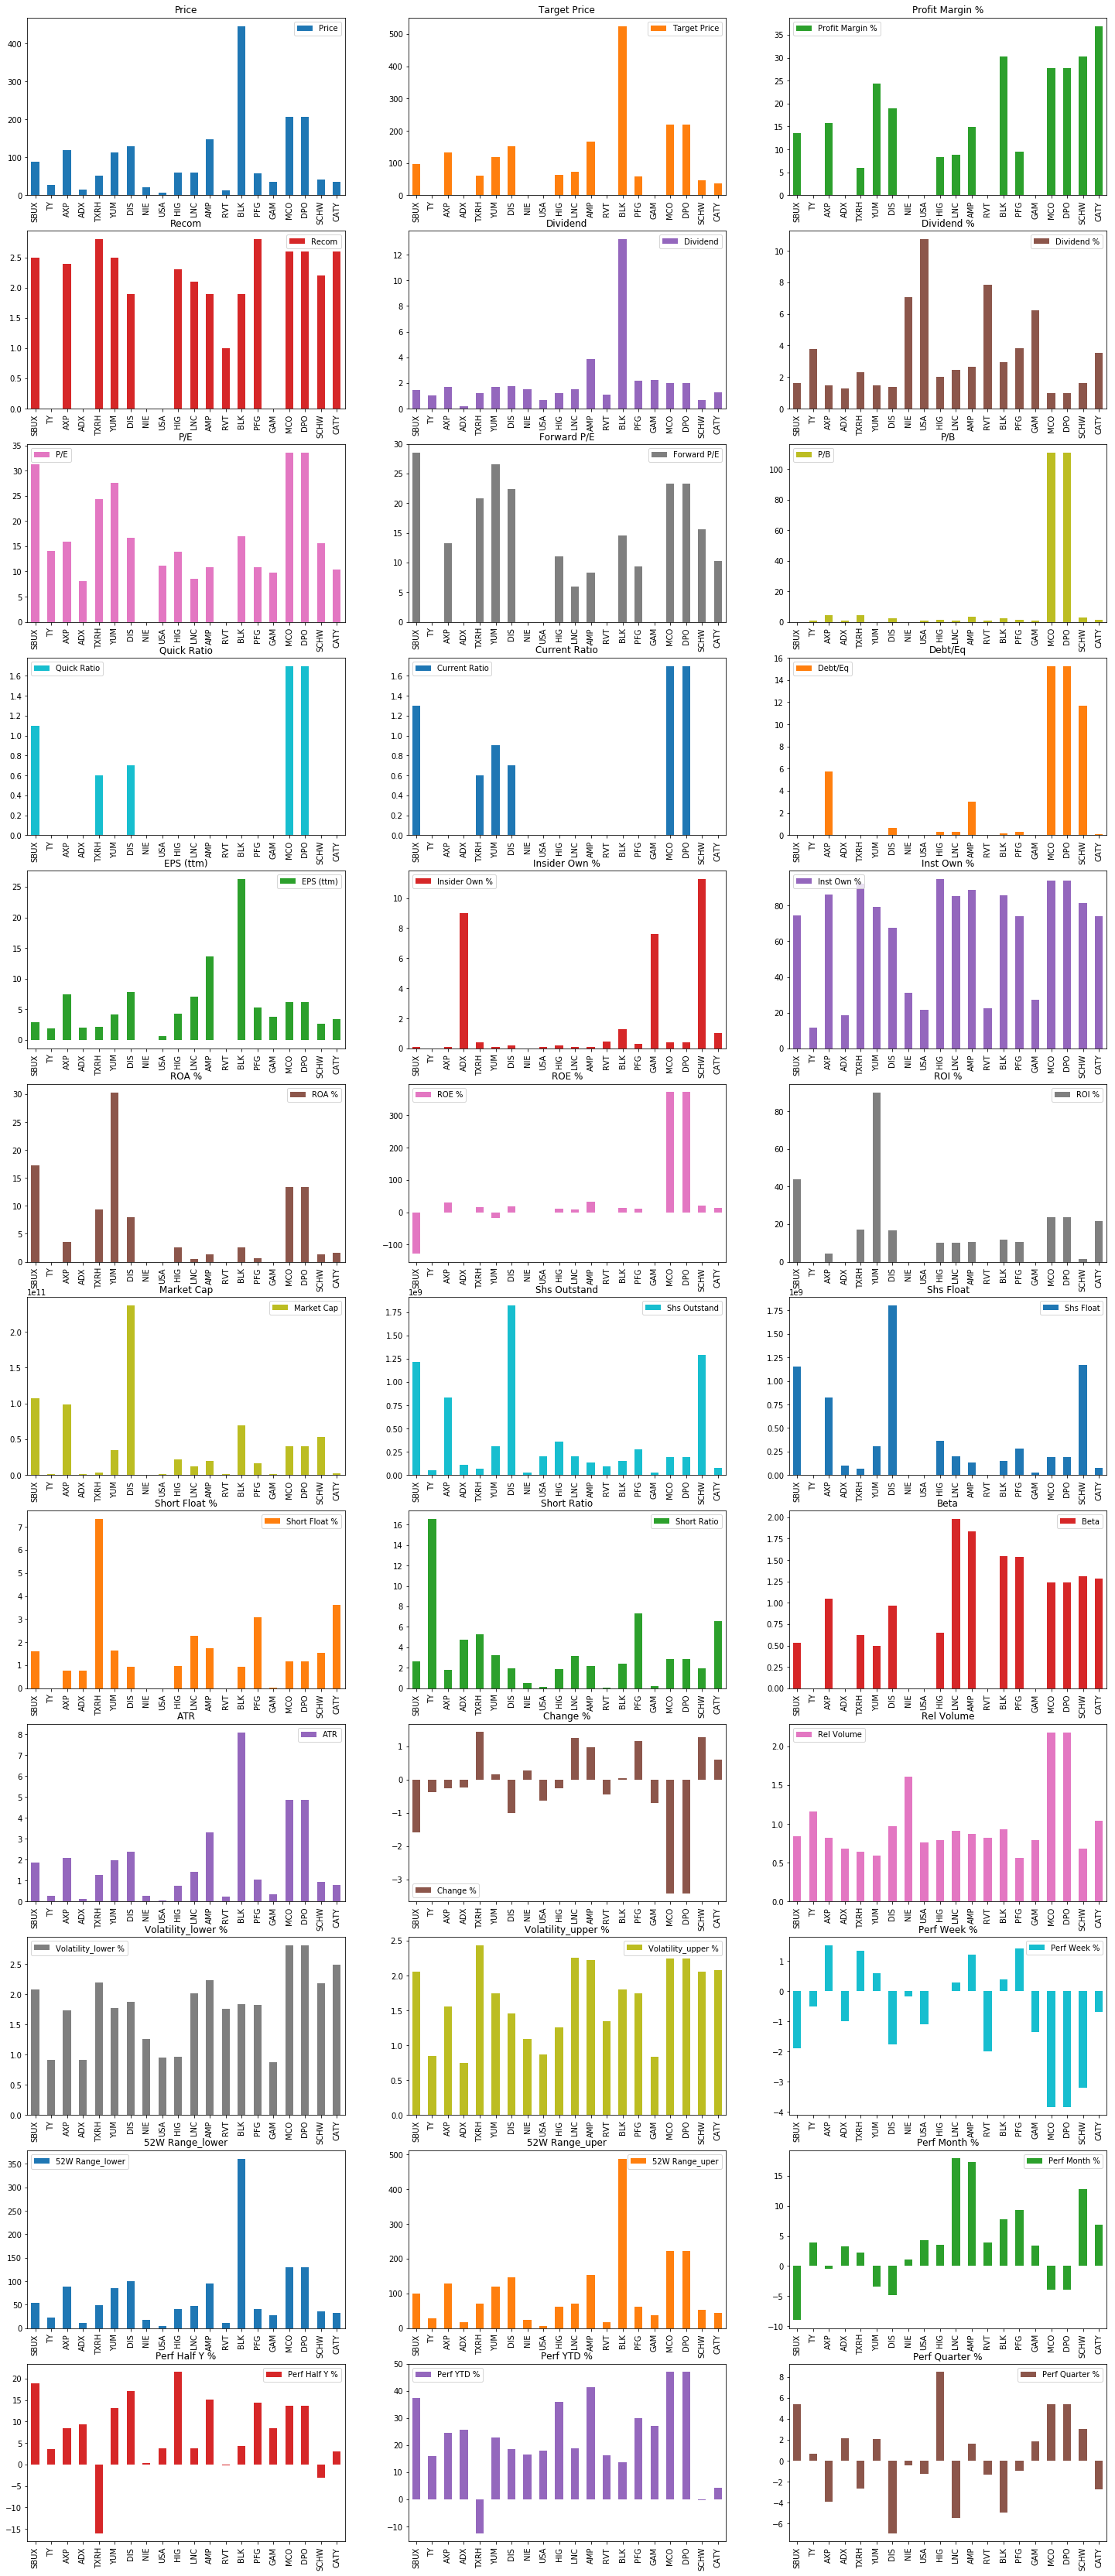

In [11]:
ax=t[["Price","Target Price","Profit Margin %",
   "Recom","Dividend","Dividend %",
   "P/E","Forward P/E","P/B",
   "Quick Ratio","Current Ratio","Debt/Eq",
   "EPS (ttm)","Insider Own %","Inst Own %",
   "ROA %","ROE %","ROI %",
  "Market Cap","Shs Outstand","Shs Float",
  "Short Float %", "Short Ratio","Beta",
  "ATR","Change %","Rel Volume",
  'Volatility_lower %','Volatility_upper %',"Perf Week %",
   '52W Range_lower', '52W Range_uper',"Perf Month %",
  'Perf Half Y %','Perf YTD %',"Perf Quarter %"]].plot(kind="bar",figsize=(25,60),subplots=True,layout=(12, 3),sharex=False);